In [41]:
import pandas as pd
pd.options.plotting.backend = "plotly"
import plotly.io as pio
pio.renderers.default = "png"
import plotly.express as px
import numpy as np
# import matplotlib.pyplot as plt
import sqlite3

# Ingesting data
con = sqlite3.connect("csgo.db")
csgo_df = pd.read_sql_query("SELECT * FROM round INNER JOIN game WHERE round.game_id = game.id", con, parse_dates=["time"])
players_df = pd.read_sql_query("SELECT * from players", con)
csgo_df['time'] = pd.to_datetime(csgo_df['time'], utc=True)
csgo_df['timeUnix'] = csgo_df['time'].apply(lambda x: x.timestamp())

# Some Pandas visual display options to read the data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### Summary variables
- Pre-processing the data to either convert it from "JSON" to a proper Python list.
- Converting some data from absolute to relative (i.e. the ticks from the start of the round)
- And then convert those data points into literal seconds, so we can see when an action took place within the context of a round

In [42]:
csgo_df['survivingCount'] =  csgo_df.survivingPlayers.apply(lambda x: len(x[1:-1].split(',')) if x != 'null' else 0)

csgo_df['longestKillWaitS'] = csgo_df['longestKillWait']/csgo_df['tickrate']
csgo_df['lastKillToEndS'] = csgo_df['lastKillToEnd']/csgo_df['tickrate']

csgo_df["team_a_players"] = csgo_df.team_a_players.apply(lambda x: sorted(map(int, x[1:-1].split(','))))
csgo_df["team_b_players"] = csgo_df.team_b_players.apply(lambda x: sorted(map(int, x[1:-1].split(','))))
csgo_df["losingPlayers"] = np.where(csgo_df["losingTeamName"] == csgo_df["team_a"],  csgo_df["team_a_players"], csgo_df["team_b_players"])
csgo_df["players"] = csgo_df["team_a_players"] + csgo_df["team_b_players"]

# Converting nade/kill ticks into relative datapoints 
csgo_df['heTicks'] = csgo_df.heTicks.apply(lambda x: sorted(map(int, x[1:-1].split(','))) if x != "null" else [])
csgo_df['heTicksRelative'] = csgo_df.apply(lambda x: [((y-x.startTick)/x.tickrate) for y in x.heTicks ], axis=1)
csgo_df['killTicksP'] = csgo_df.killTicks.apply(lambda x: sorted(map(int, x[1:-1].split(','))) if x != "null" else [])
csgo_df['killTicksRelative'] = csgo_df.apply(lambda x: [((y-x.startTick)/x.tickrate) for y in x.killTicksP], axis=1)
csgo_df['smokeTicks'] = csgo_df.smokeTicks.apply(lambda x: sorted(map(int, x[1:-1].split(','))) if x != "null" else [])
csgo_df['smokeTicksRelative'] = csgo_df.apply(lambda x: [((y-x.startTick)/x.tickrate) for y in x.smokeTicks], axis=1)
csgo_df['molotovTicks'] = csgo_df.molotovTicks.apply(lambda x: sorted(map(int, x[1:-1].split(','))) if x != "null" else [])
csgo_df['molotovTicksRelative'] = csgo_df.apply(lambda x: [((y-x.startTick)/x.tickrate) for y in x.molotovTicks], axis=1)

In [43]:
csgo_df
;

''

### Seasonal averages
- Yearly and Monthly averages.
- Monthly averages can get a bit skewed with the limited data set (as majors can spill across months), so yearly is used exclusively.


In [44]:
yearly_average = csgo_df.resample("Y", on="time")
yearly_average.mean().dropna()
;

/tmp/ipykernel_28186/1524761603.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



''

In [45]:
monthly_average = csgo_df.resample("M", on="time")
monthly_average.mean().dropna()
;

/tmp/ipykernel_28186/330764374.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



''

### Plotting basic data points

#### Average duration of a round

/tmp/ipykernel_28186/1270723649.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



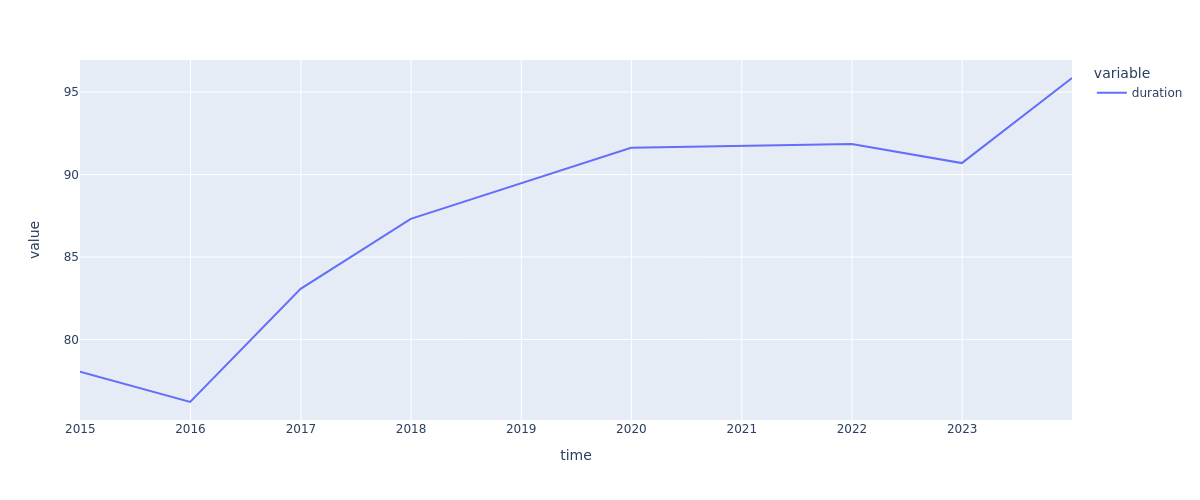

In [46]:
yearly_average[["time", "duration"]].mean().dropna().plot(width=1200)

#### Average number of players surviving at the end of a round (where end of a round is after the round outcome decided, but before the restart)

/tmp/ipykernel_28186/4233631466.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



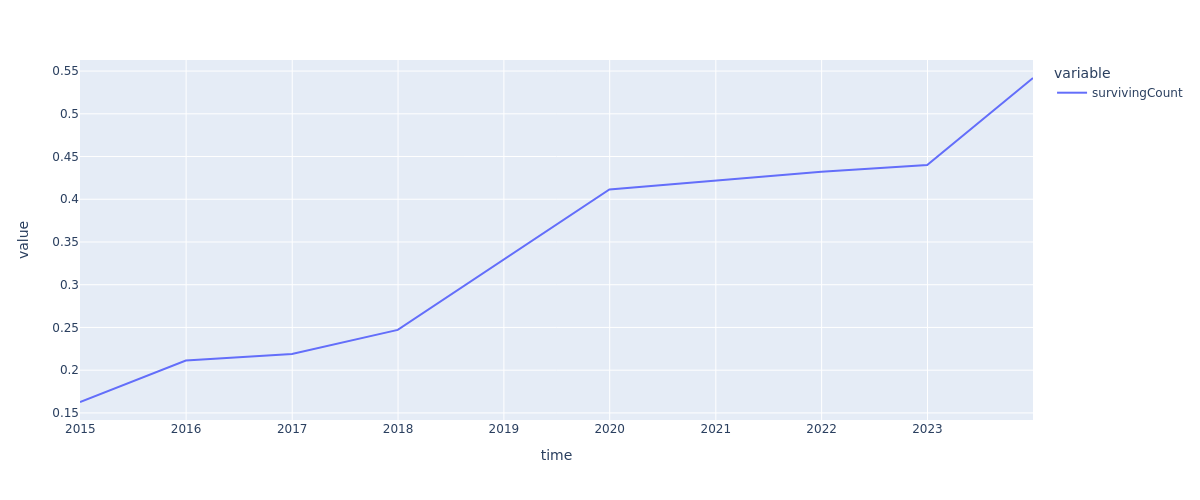

In [47]:
yearly_average[["time", "survivingCount"]].mean().dropna().plot(width=1200)

/tmp/ipykernel_28186/1931466050.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



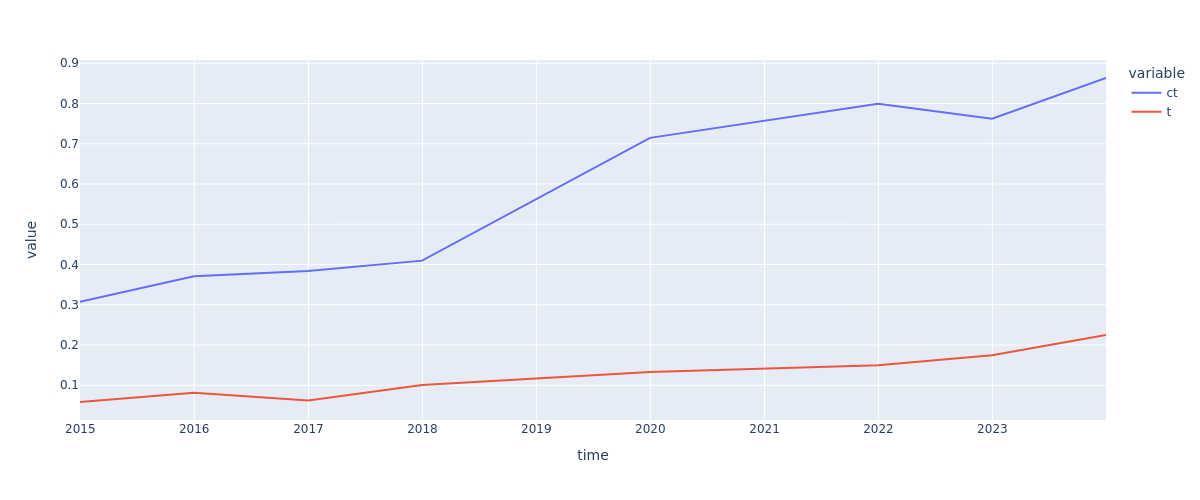

In [48]:
operation_cannot_possibly_fail = csgo_df.resample("Y", on="time").mean().dropna()
operation_cannot_possibly_fail["t"] = csgo_df.loc[csgo_df["losingSide"] == 2].resample("Y", on="time")[["survivingCount"]].mean().dropna()
operation_cannot_possibly_fail["ct"] = csgo_df.loc[csgo_df["losingSide"] == 3].resample("Y", on="time")[["survivingCount"]].mean().dropna()
operation_cannot_possibly_fail[["ct", "t"]].plot(width=1200)

#### Average damage from HE nades during a round
The 2013/2014 data is suspect.

/tmp/ipykernel_28186/3920590922.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



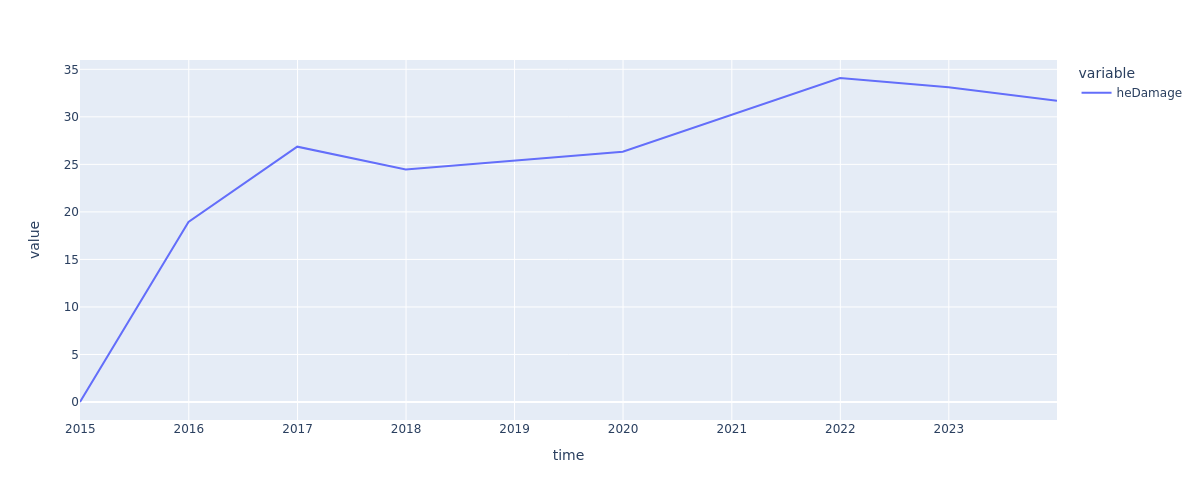

In [49]:
yearly_average[['time', 'heDamage']].mean().dropna().plot(width=1200)

#### The average longest duration between kills in a round

/tmp/ipykernel_28186/158865161.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



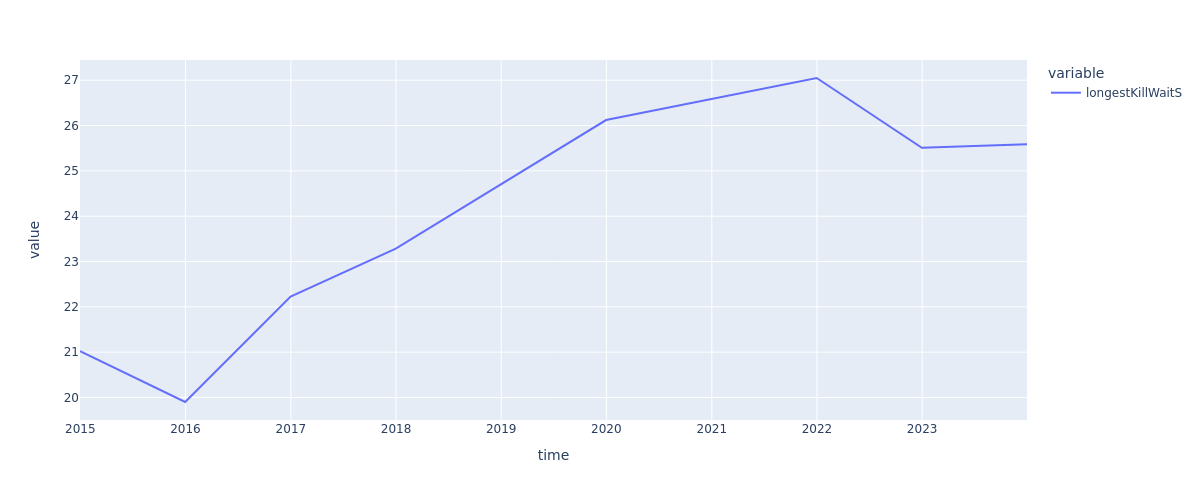

In [50]:
yearly_average[["time", "longestKillWaitS"]].mean().dropna().plot(width=1200)

#### Average duration from the last kill to the end of a round

/tmp/ipykernel_28186/1712028614.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



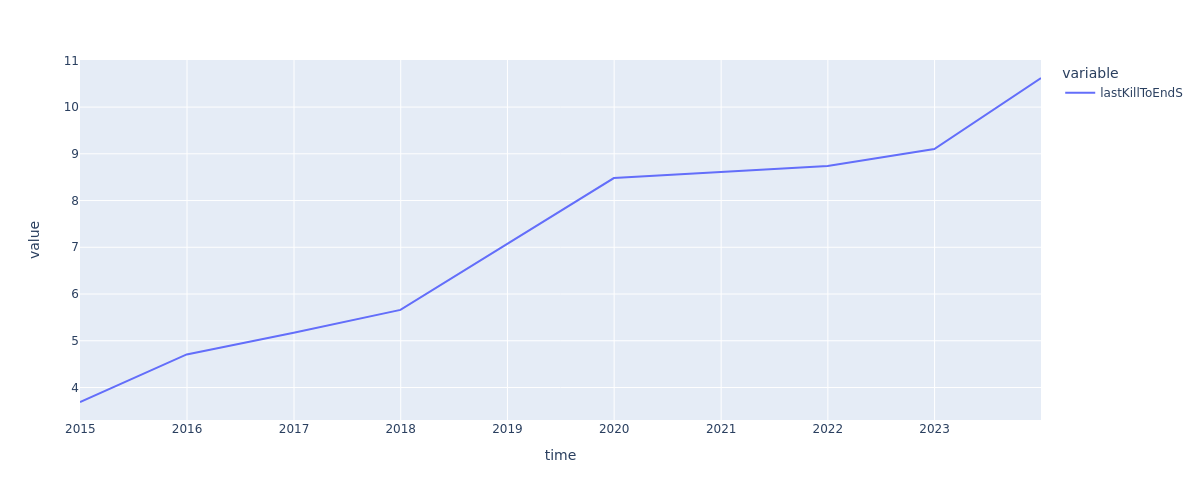

In [51]:
yearly_average[['time', 'lastKillToEndS']].mean().dropna().plot(width=1200)

#### Average point of a kill in a round

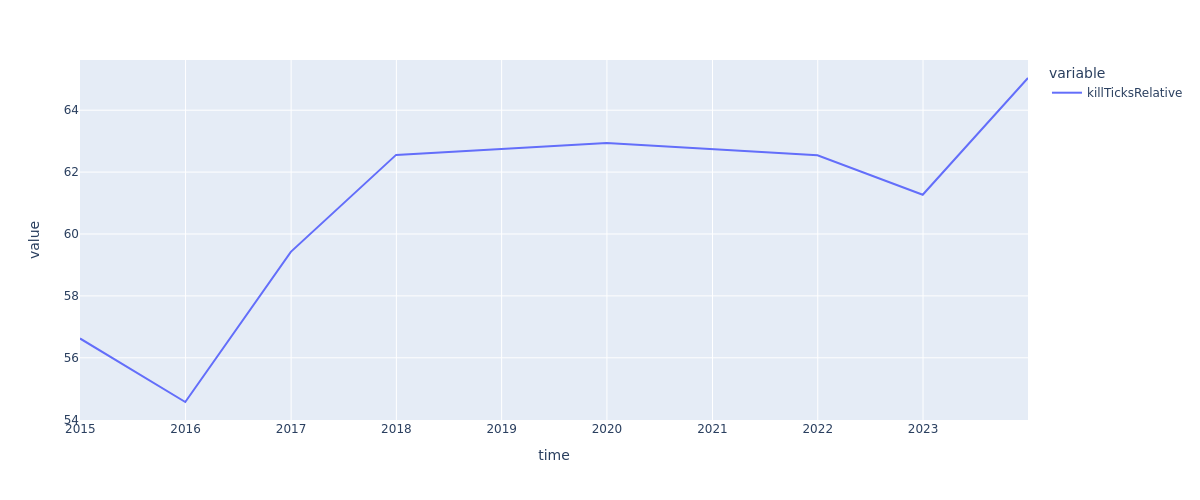

In [52]:
csgo_df[['time', 'killTicksRelative']].explode('killTicksRelative').resample("Y", on="time").mean().dropna().plot(width=1200)

#### Nade relative graphs

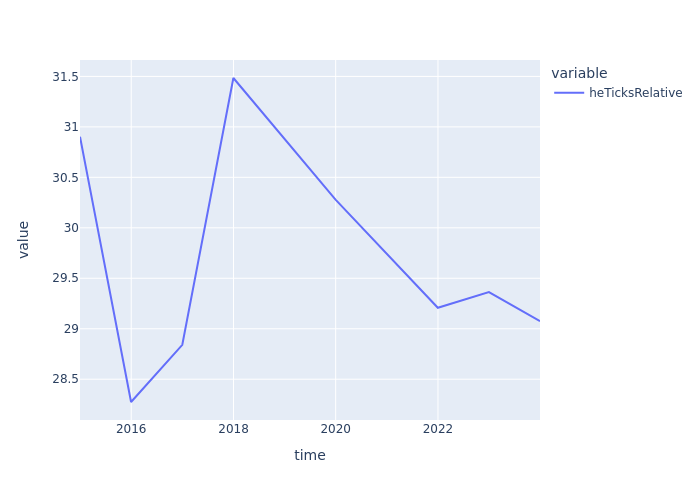

In [53]:
heG = csgo_df[['time', 'heTicksRelative']].explode('heTicksRelative').resample("Y", on="time").mean().dropna()
heG.plot()

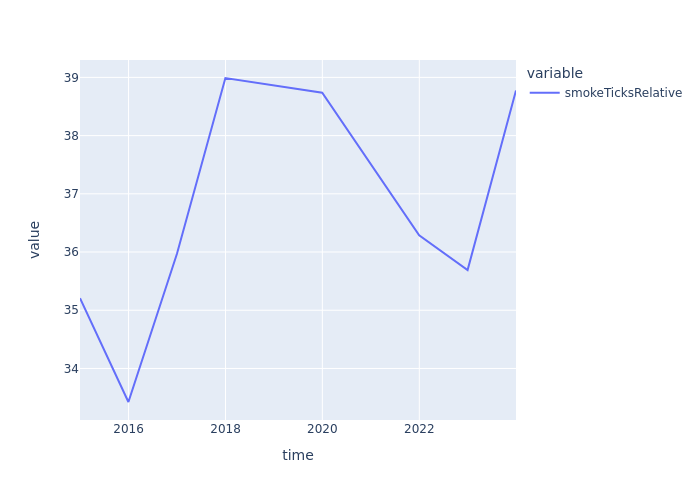

In [54]:
smokeG = csgo_df[['time', 'smokeTicksRelative']].explode('smokeTicksRelative').resample("Y", on="time").mean().dropna()
smokeG.plot()

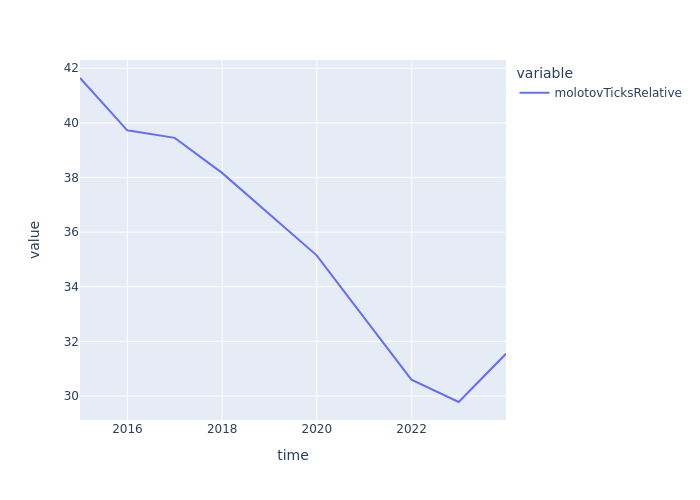

In [55]:
moloG = csgo_df[['time', 'molotovTicksRelative']].explode('molotovTicksRelative').resample("Y", on="time").mean().dropna()
moloG.plot()

In [56]:
# csgo_df[['time', 'smokeTicksRelative', 'molotovTicksRelative', 'heTicksRelative']].explode('smokeTicksRelative').explode('molotovTicksRelative').explode('heTicksRelative').resample("Y", on="time").mean().dropna().plot(width=1200)

Average play date for a player

In [57]:
time = csgo_df[["players", "timeUnix"]].explode("players").groupby("players").agg(list)
time["avgGameDate"] = time["timeUnix"].apply(np.mean)
time["firstGameDate"] = time["timeUnix"].apply(lambda x: sorted(x)[0])
# time["avgGameDate"] = time["avgGameDate"].apply(lambda x: pd.to_datetime(x, unit='s'))
time = time[["avgGameDate", "firstGameDate"]]


### Calculating the players that save the most

In [58]:
survivingRounds = csgo_df.loc[csgo_df["survivingCount"] > 0]
survivingRounds
;

''

This is not a list of the most saved players - it is a list of players on teams that save the most. 

dupreeh hasn't saved 235 times, the teams he's been on have.


In [59]:
survivingRounds.losingPlayers.explode().value_counts().to_frame().reset_index().rename(columns={"index":"SteamID64", "losingPlayers": "roundsSaved"}).merge(players_df).merge(time, left_on="SteamID64", right_on="players")[['name', 'roundsSaved', 'apps', 'avgGameDate', 'firstGameDate']].groupby('roundsSaved').agg(list)

,name,apps,avgGameDate,firstGameDate
roundsSaved,,,,
1,"[Detrony #INTEL, HUNDEN, natu, deviaNt #COREX, KHRN, disturbed, stonde, xartE, racno-.`SGMF.<..>, cent #ALIENWARE, blackpoisoN #RAZER, AcilioN]","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[1417101316.3636363, 1417130644.3255813, 1426249272.1111112, 1417101316.3636363, 1426249272.1111112, 1426249272.1111112, 1426249272.1111112, 1426249272.1111112, 1417101316.3636363, 1417101316.3636363, 1417101316.3636363, 1417130644.3255813]","[1417094224.0, 1417119994.0, 1426249166.0, 1417094224.0, 1426249166.0, 1426249166.0, 1426249166.0, 1426249166.0, 1417094224.0, 1417094224.0, 1417094224.0, 1417119994.0]"
2,"[desi, WOLF > astaRRRRR, WOLF > RiTz, WOLF > Mithil:D, WOLF > Ace, WOLF > R i X, oSee]","[3, 2, 2, 2, 2, 2, 1]","[1417102882.0869565, 1408008280.4390244, 1408008280.4390244, 1408008280.4390244, 1408008280.4390244, 1408008280.4390244, 1667687383.0]","[1417096564.0, 1408006766.0, 1408006766.0, 1408006766.0, 1408006766.0, 1408006766.0, 1667687383.0]"
3,"[ptr, steel * ADATA, ub1que, yam, zEVES, Polly * XTRFY]","[3, 4, 2, 3, 3, 5]","[1426249168.0810812, 1408071168.1298702, 1408028929.8139534, 1440146557.5714285, 1426248747.4264705, 1419824522.6190476]","[1426248915.0, 1408028030.0, 1408025982.0, 1440084565.0, 1426248551.0, 1408015130.0]"
4,"[DEVIL, THREAT]","[2, 7]","[1467846992.1020408, 1459891430.897143]","[1467846532.0, 1459888616.0]"
5,"[rallen, Hyper, Furlan, koosta, pita, [R]eason EXR * SteelSeries, HS, zehN, innocent, suNny, peet, GruBy, [R]eason LOMME * SteelSeries]","[7, 4, 4, 2, 2, 3, 3, 3, 6, 3, 4, 4, 3]","[1435523780.8390806, 1449456017.7575758, 1449456017.7575758, 1467846560.2727273, 1467846560.2727273, 1394753036.6197183, 1500339430.95, 1500339430.95, 1460078365.0580645, 1500339430.95, 1449456017.7575758, 1449456017.7575758, 1394753036.6197183]","[1417120260.0, 1440093693.0, 1440093693.0, 1467846293.0, 1467846293.0, 1394749824.0, 1500234703.0, 1500234703.0, 1417120260.0, 1500234703.0, 1440093693.0, 1440093693.0, 1394749824.0]"
...,...,...,...,...
212,[Zeus],[89],[1472910707.8643217],[1394749266.0]
216,[olofmeister],[109],[1471422073.5936472],[1394749266.0]
228,[s1mple],[85],[1571188781.0213656],[1417098504.0]


#### Players that have saved the most 

In [60]:
csgo_df["survivingPlayers"] = csgo_df.survivingPlayers.apply(lambda x: sorted(map(int, x[1:-1].split(','))) if x != 'null' else None)
savingPlayers = csgo_df.survivingPlayers.explode().value_counts().to_frame().reset_index(names="SteamID64").rename(columns={"survivingPlayers": "roundsSurvived"}).merge(players_df).merge(time, left_on="SteamID64", right_on="players")

In [61]:
savingPlayers[['name', 'roundsSurvived', 'avgGameDate', 'firstGameDate']].groupby('roundsSurvived').agg(list)

,name,avgGameDate,firstGameDate
roundsSurvived,,,
1,"[HaRtsSsSsSs * ZOWIE GEAR, AcilioN, Professor_Chaos, STYKO, cent #ALIENWARE, [R]eason EXR * SteelSeries, zehN, DEVIL, zEVES, Golden, rallen, GruBy, innocent, xartE, SENER1, yam, LEGIJA, ub1que, rigoN, DavCost, jR, hooch]","[1394754438.1818182, 1417130644.3255813, 1459888795.6842105, 1485252160.4, 1417101316.3636363, 1394753036.6197183, 1500339430.95, 1467846992.1020408, 1426248747.4264705, 1567116725.1702127, 1435523780.8390806, 1449456017.7575758, 1460078365.0580645, 1426249272.1111112, 1667763706.875817, 1440146557.5714285, 1485262984.2108433, 1408028929.8139534, 1667763706.875817, 1441944112.121951, 1500274342.9210527, 1466155986.0089285]","[1394749876.0, 1417119994.0, 1459888754.0, 1485194636.0, 1417094224.0, 1394749824.0, 1500234703.0, 1467846532.0, 1426248551.0, 1567025562.0, 1417120260.0, 1440093693.0, 1417120260.0, 1426249166.0, 1667660477.0, 1440084565.0, 1394733492.0, 1408025982.0, 1667660477.0, 1426248703.0, 1500222206.0, 1459888779.0]"
2,"[Hyper, pyth, fel1x *Platincasino, Furlan, smF, zqkS, koosta, iBP anger, AZK * ASRock, zonic, krystaLAW *Platincasino, Troubley * WorldofCDKeys.com, EPSILON Sf * GAMDIAS, oskar, abE, steel * ADATA, THREAT, Havoc[K] MSi, SPUNJ MSi, USTILO, suNny, WOLF > RiTz, keshandr, SIXER]","[1449456017.7575758, 1467892759.322034, 1417134293.0894308, 1449456017.7575758, 1403193713.2105262, 1426290719.7708333, 1467846560.2727273, 1394751883.8823528, 1409945720.8994083, 1467993434.7307692, 1441665535.025641, 1423609759.7142856, 1403122982.1268294, 1500348457.940678, 1459888795.6842105, 1408071168.1298702, 1459891430.897143, 1419997689.3004694, 1419997689.3004694, 1440130268.8431373, 1500339430.95, 1408008280.4390244, 1500274342.9210527, 1485324054.4395604]","[1440093693.0, 1467846474.0, 1417093584.0, 1440093693.0, 1394749824.0, 1426248960.0, 1467846293.0, 1394749914.0, 1394749914.0, 1467912161.0, 1417093584.0, 1417122290.0, 1394749876.0, 1500216334.0, 1459888754.0, 1408028030.0, 1459888616.0, 1394725222.0, 1394725222.0, 1440093641.0, 1500234703.0, 1408006766.0, 1500222206.0, 1485197964.0]"
3,"[lauNX, sinnopsyy, juanflatroo, LDLC.com KQLY Cooler Master, svyat, Zero, SnypeR, James, emagine, HS, keev, pita, spaze, swag * Intel]","[1667773160.3175676, 1667763706.875817, 1667763706.875817, 1405138635.3904283, 1567112264.3297873, 1485252160.4, 1417654342.128713, 1440130268.8431373, 1440130268.8431373, 1500339430.95, 1500563743.4577465, 1467846560.2727273, 1467956907.5632184, 1403626348.4275863]","[1667665573.0, 1667660477.0, 1667660477.0, 1394725222.0, 1566994692.0, 1485194636.0, 1394725222.0, 1440093641.0, 1440093641.0, 1500234703.0, 1500325975.0, 1467846293.0, 1467846293.0, 1394749876.0]"
4,"[XANTARES, Zellsis, daps, CW Nico * Komplett, DaZeD Netcodeguides.com, Staehr, FNS, LDLC.com Uzzziii Cooler Master, arya, Lucky, gade, peet, mir, doto, cype * Gunnar Optics, zews, ANNIHILATION, speed4k, kinqie, fR11$HAAA]","[1550728027.3962264, 1550917703.3357663, 1525282553.4836602, 1408061871.2105262, 1402764265.8125, 1667773160.3175676, 1441480637.3854167, 1405138635.3904283, 1459888795.6842105, 1635722663.662069, 1567172172.3028169, 1449456017.7575758, 1500274342.9210527, 1635657186.2637362, 1394892599.4312797, 1567156153.2719297, 1675615580.467742, 1567112264.3297873, 1567112264.3297873, 1403193713.2105262]","[1550668474.0, 1550683526.0, 1467846474.0, 1408017092.0, 1394749914.0, 1667665573.0, 1426248915.0, 1394725222.0, 1459888754.0, 1635608582.0, 1567009186.0, 1440093693.0, 1500222206.0, 1635601087.0, 1394749266.0, 1567025562.0, 1675544361.0, 1566994692.0, 1566994692.0, 1394749824.0]"
5,"[maden, Cloud9 CS seM <ALIENware>, JT, tiziaN, Pimp, disco doplan, Devilwalk.teg * Fragnet]","[1660475078.7694445, 1408141012.8156424, 1675728511.9346404, 1578468160.7860262, 1443873132.1973245, 1485472879.4795918, 1394847643.556962]","[1652725106.0, 1394749876.0, 1675609387.0, 1394733492.0, 1394733574.0, 1485213903.0, 1394749824.0]"
...,...,...,...
82,[NAF],[1613223684.74

### Calculating the ratio of appearances within the dataset, and the amount they save

In [62]:
savingPlayers['mostSaved'] = savingPlayers['roundsSurvived']/savingPlayers['apps']
savingPlayers["avgGameDate"] = savingPlayers["avgGameDate"].apply(lambda x: pd.to_datetime(x, unit='s'))
savingPlayers["firstGameDate"] = savingPlayers["firstGameDate"].apply(lambda x: pd.to_datetime(x, unit='s'))

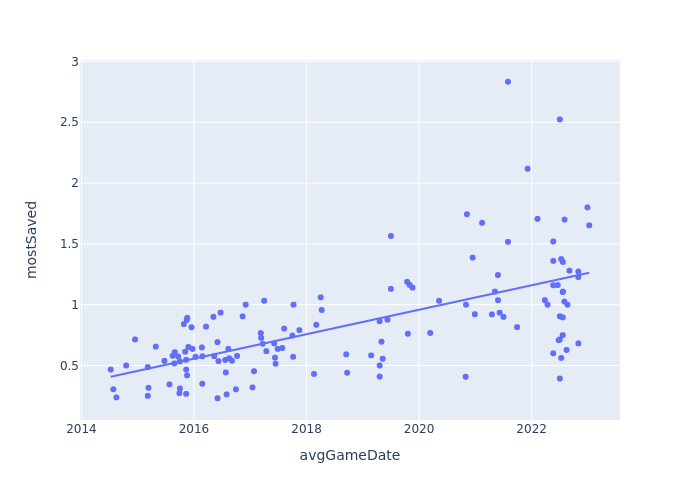

In [63]:
fig = px.scatter(savingPlayers.loc[savingPlayers['apps'] > 20 ], y="mostSaved", x="avgGameDate", hover_data=["name"], trendline="ols")
# fig.update_yaxes(visible=False)
fig.show()
fig.write_html("savingCountVsAvgDate.html")

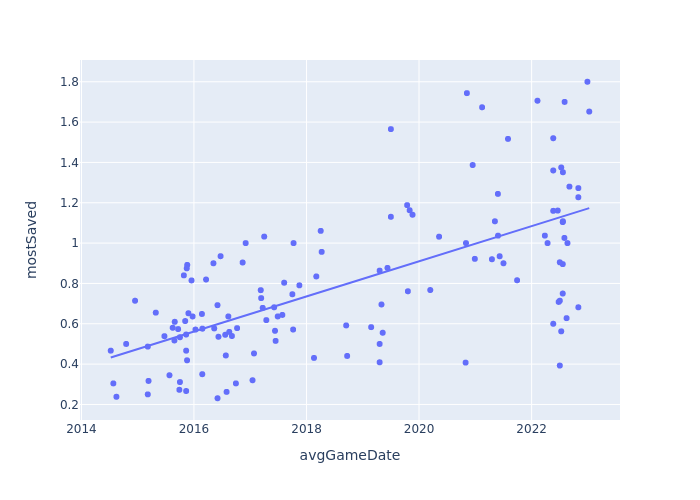

In [64]:
fig = px.scatter(savingPlayers.loc[savingPlayers['apps'] > 20 ].loc[savingPlayers['mostSaved'] < 2], y="mostSaved", x="avgGameDate", hover_data=["name"], trendline="ols")
# fig.update_yaxes(visible=False)
fig.show()
fig.write_html("savingCountVsAvgDateNoOutliers.html")

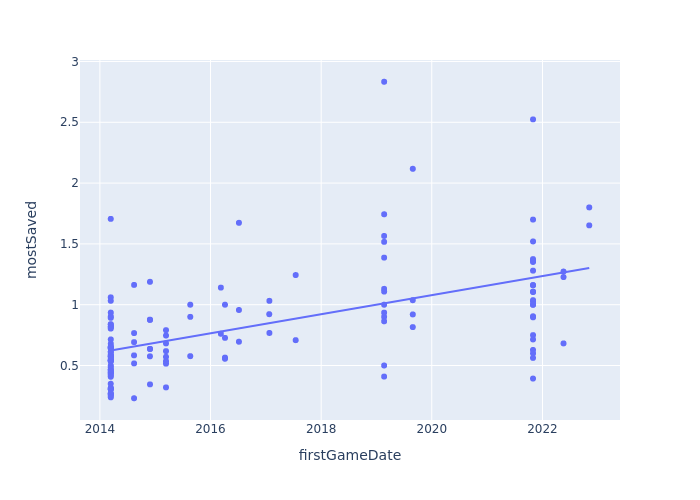

In [65]:
fig = px.scatter(savingPlayers.loc[savingPlayers['apps'] > 20 ], y="mostSaved", x="firstGameDate", hover_data=["name"], trendline="ols")
# fig.update_yaxes(visible=False)
fig.show()
fig.write_html("savingCountVsFirstDate.html")

#### Players with the lowest survival/appearances ratio, with a minimum of 20 maps played

In [66]:
savingPlayers.loc[savingPlayers['apps'] > 20 ].sort_values(by='mostSaved').head(20)[['name', 'apps', 'roundsSurvived', 'mostSaved', 'avgGameDate', 'firstGameDate']]

,name,apps,roundsSurvived,mostSaved,avgGameDate,firstGameDate
232,B1ad3,26,6,0.230769,2016-06-02 01:17:28.033576704,2014-08-14 14:19:42
234,Cloud9 CS seM <ALIENware>,21,5,0.238095,2014-08-15 22:16:52.815642368,2014-03-13 22:31:16
114,friberg,76,19,0.250000,2015-03-07 10:34:21.792158976,2014-03-13 16:09:50
133,dennis,61,16,0.262295,2016-07-30 22:19:38.941914112,2014-03-13 22:21:06
111,byali,75,20,0.266667,2015-11-11 14:32:35.523359488,2014-03-13 15:37:22
230,ANGE1,22,6,0.272727,2015-09-28 12:00:11.140115200,2014-03-13 15:37:22
219,FeTiSh[MB],23,7,0.304348,2014-07-26 21:11:47.204796928,2014-03-13 22:31:54
214,MSL,23,7,0.304348,2016-09-29 11:36:01.519933440,2014-03-13 17:59:34
77,f0rest,90,28,0.311111,2015-10-02 04:07:28.404904960,2014-03-13 16:09:50
117,pronax,60,19,0.316667,2015-03-12 07:10:42.713903616,2014-03-13 22:30:24


#### Players with the highest survival/appearances ratio, with a minimum of 20 maps played

In [67]:
savingPlayers.loc[savingPlayers['apps'] > 20 ].sort_values(by='mostSaved', ascending=False).head(20)[['name', 'apps', 'roundsSurvived', 'mostSaved', 'avgGameDate', 'firstGameDate']]

,name,apps,roundsSurvived,mostSaved,avgGameDate,firstGameDate
0,Jame,60,170,2.833333,2021-07-31 14:17:46.026797312,2019-02-20 17:16:00
21,sh1ro,21,53,2.523810,2022-07-02 20:37:13.749097472,2021-10-30 13:38:07
8,frozen,34,72,2.117647,2021-12-05 21:10:42.171461376,2019-08-28 17:41:37
36,fame,25,45,1.800000,2022-12-29 02:41:03.987381760,2022-11-05 17:52:05
10,buster,39,68,1.743590,2020-11-06 19:20:19.470588160,2019-02-20 17:16:00
4,cadiaN,51,87,1.705882,2022-02-08 00:43:46.359869952,2014-03-13 17:58:12
11,FL1T,40,68,1.700000,2022-08-03 02:51:51.168768256,2021-10-30 13:38:21
5,NAF,49,82,1.673469,2021-02-13 13:41:24.743243264,2016-07-06 23:07:54
50,oSee,23,38,1.652174,2023-01-09 23:23:34.567901184,2022-11-05 16:25:50
60,Liazz,23,36,1.565217,2019-07-02 09:11:19.021582848,2019-02-20 13:16:38


In [68]:
csgo_df.losingPlayers.explode().value_counts().to_frame().reset_index().rename(columns={"index":"SteamID64", "losingPlayers": "roundsPlayed"}).merge(players_df)


,SteamID64,roundsPlayed,name,apps
0,76561198004854956,1350,dupreeh,121
1,76561197988627193,1273,olofmeister,109
2,76561197989744167,1254,apEX,98
3,76561198031651584,1187,KRIMZ,102
4,76561197987713664,1179,device,109
...,...,...,...,...
356,76561197960677505,30,arya,2
357,76561197963561698,30,cent #ALIENWARE,2
358,76561197996060155,6,raalzZZzz * Razer,1
359,76561197969695108,5,oSee,1


## Players that take the most amount of time to lose

In [69]:
durations = csgo_df.explode("losingPlayers").reset_index()[["duration", "losingPlayers"]].rename(columns={"losingPlayers": "SteamID64"}).merge(players_df).merge(time, left_on="SteamID64", right_on="players")[["duration", "name", "apps", "avgGameDate", "firstGameDate"]]

### Players that took the least amount of time to lose

In [70]:
dur = durations.loc[durations['apps'] > 20 ].groupby('name').agg(list).applymap(np.mean)
dur["avgGameDate"] = dur["avgGameDate"].apply(lambda x: pd.to_datetime(x, unit='s'))
dur["firstGameDate"] = dur["firstGameDate"].apply(lambda x: pd.to_datetime(x, unit='s'))
dur.sort_values(by='duration').head(30)

,duration,apps,avgGameDate,firstGameDate
name,,,,
FeTiSh[MB],74.316872,23.0,2014-07-26 21:11:47.204797184,2014-03-13 22:31:54
Skadoodle,74.748428,23.0,2015-11-26 05:12:15.561938944,2014-03-13 22:31:54
seang@res,74.805930,28.0,2014-12-14 20:11:20.019580928,2014-03-13 22:31:16
Spiidi,75.237537,24.0,2015-11-15 10:29:42.983579648,2014-11-27 13:06:24
SmithZz,75.885827,39.0,2015-06-23 13:59:39.062039808,2014-03-13 15:45:56
shroud,76.576826,29.0,2015-08-27 04:55:20.674634496,2014-08-14 18:31:04
Cloud9 CS seM <ALIENware>,76.930147,21.0,2014-08-15 22:16:52.815642368,2014-03-13 22:31:16
ScreaM,77.028902,25.0,2015-10-27 13:28:36.135042304,2014-03-13 15:45:56
denis,77.868922,33.0,2016-02-24 23:02:31.804449536,2014-11-27 13:06:24


### Players that took the most amount of time to lose

In [71]:
dur.sort_values(by='duration', ascending=False).head(30)

,duration,apps,avgGameDate,firstGameDate
name,,,,
fame,105.787456,25.0,2022-12-29 02:41:03.987381504,2022-11-05 17:52:05
FL1T,105.079918,40.0,2022-08-03 02:51:51.168768768,2021-10-30 13:38:21
Jame,103.323138,60.0,2021-07-31 14:17:46.026797824,2019-02-20 17:16:00
Qikert,103.323138,60.0,2021-07-31 14:17:46.026797824,2019-02-20 17:16:00
buster,101.956190,39.0,2020-11-06 19:20:19.470588160,2019-02-20 17:16:00
YEKINDAR,99.726166,39.0,2022-08-01 19:19:48.177845248,2021-10-30 13:38:21
Boombl4,98.124542,25.0,2021-04-18 06:03:41.808641792,2019-08-28 19:40:50
oSee,96.766551,23.0,2023-01-09 23:23:34.567901440,2022-11-05 16:25:50
b1t,96.187500,37.0,2022-07-23 01:16:38.103773696,2021-10-30 15:40:43


In [72]:
fig = px.scatter(dur, y="duration", x="avgGameDate", hover_data={"name": dur.index}, trendline="ols")
# fig.update_yaxes(visible=False)
fig.show()
fig.write_html("roundDurationVsGameDate.html")

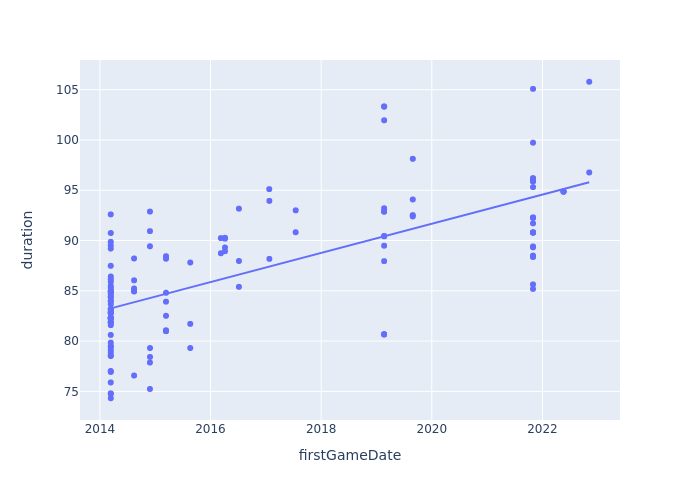

In [ ]:
fig = px.scatter(dur, y="duration", x="firstGameDate", hover_data={"name": dur.index}, trendline="ols")
# fig.update_yaxes(visible=False)
fig.show()
fig.write_html("roundDurationVsFirstGameDate.html")